Using TensorFlow backend.


{'data_root': '/media/tanke/Data/datasets/cmu_panoptic',
 'nodes': [1, 15, 12, 3, 12, 14],
 'panels': [1, 6, 9, 14, 16, 19],
 'seq_name': '160422_ultimatum1'}
Instructions for updating:
Colocations handled automatically by placer.


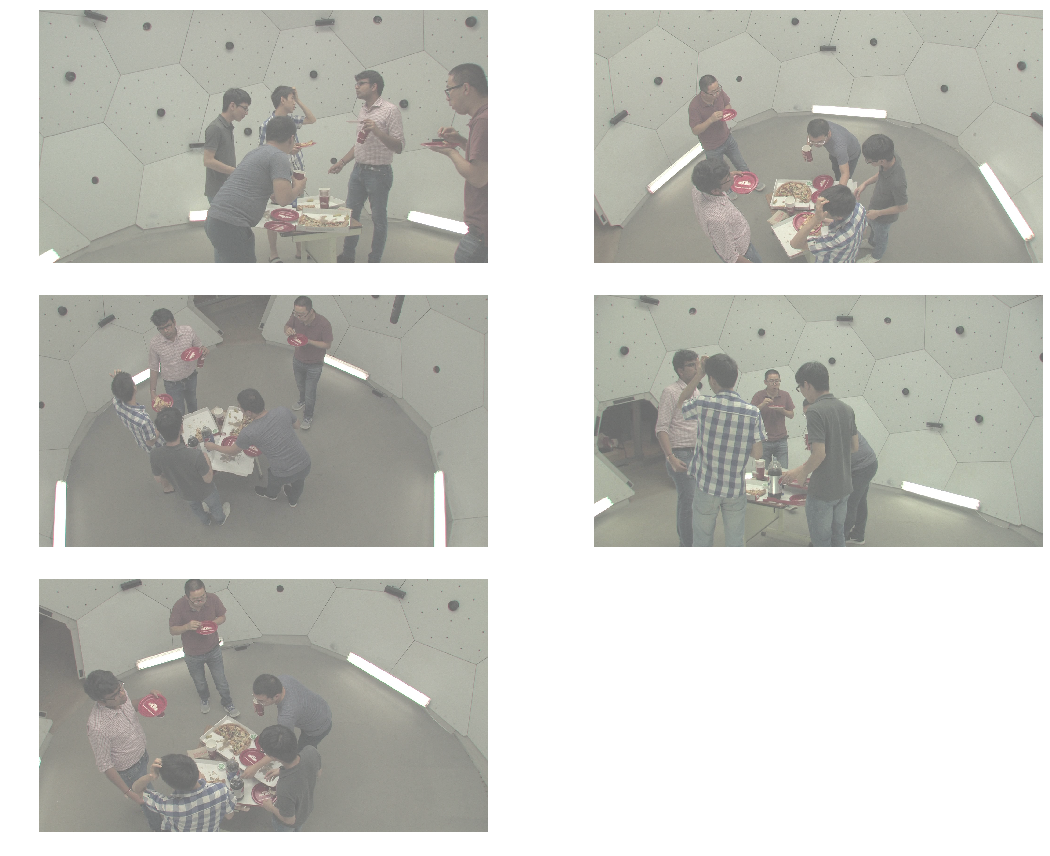

In [1]:
%matplotlib inline
# ---- settings ----
import json
from pprint import pprint
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
sys.path.insert(0, '../evaluation')
sys.path.insert(0,'../debugging')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time
from mvpose import settings

from mvpose.data import cmu_panoptic


# params = settings.get_settings(
#     max_epi_distance=40, 
#     scale_to_mm=10, 
#     gp_max_radius=50,
#     pp_conflict_overlap=0.8)

# params = settings.get_settings(
#     ms_radius=400,
#     max_epi_distance=40, 
#     scale_to_mm=10, 
#     gp_max_radius=50,
#     pp_conflict_overlap=0.7)


root = Settings['CMU']['data_root']
tmp = Settings['tmp']

pprint(Settings['CMU'])

FRAME = 2000
FRAME = 8642
#FRAME = 3700
FRAME = 500


nodes = [0, 1, 2, 3, 4]
panels = [0, 0, 0, 0, 0]
#seq_name = '160422_ultimatum1'
#seq_name = '160224_haggling1'
#seq_name = '160422_mafia2'
seq_name = '160906_pizza1'


Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)

from openpose import OpenPose

pe = OpenPose(tmp=tmp)

pred_name = 'cvpr_cmu_' + seq_name
predictions = pe.predict(Im, pred_name, FRAME)


from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human


fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'yellow', 'cyan', 'orange', 
          'teal', 'white', 'cornflowerblue', 'limegreen']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(3,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    ax.set_xlim([0, 1920])
    ax.set_ylim([1080, 0])
    
plt.tight_layout()
plt.show()

#people 5


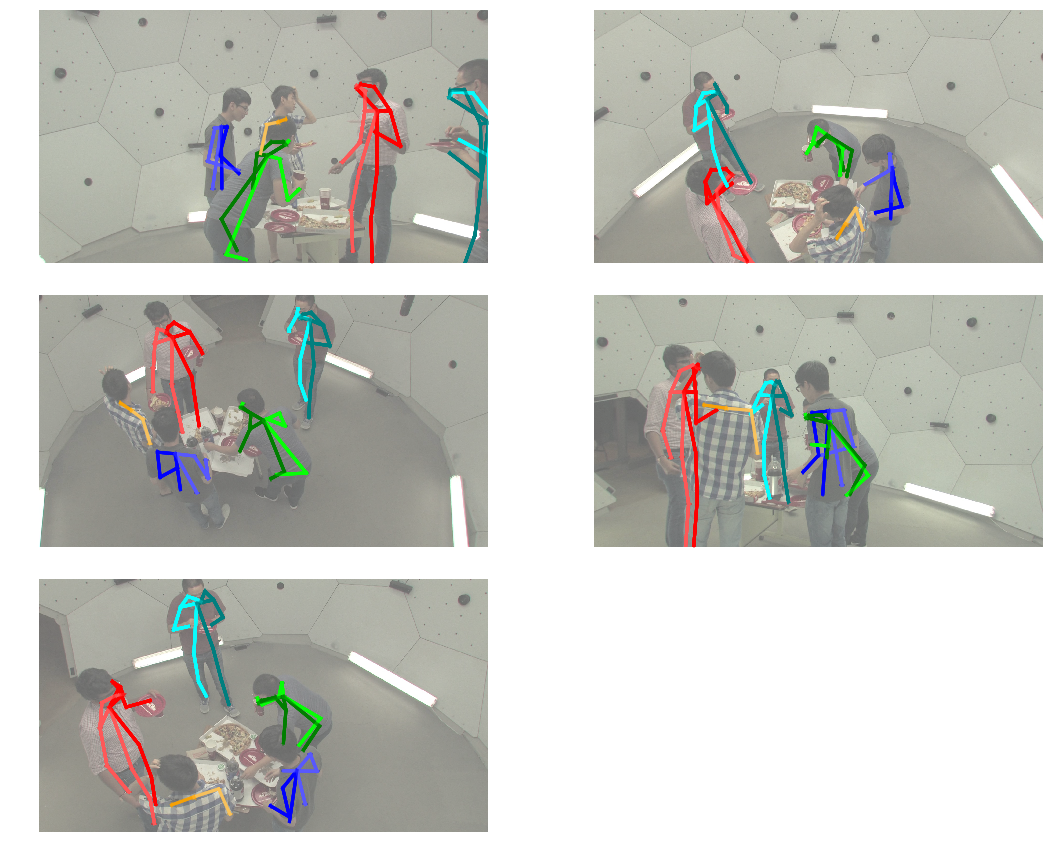

In [2]:
from mvpose.baseline.baseline import estimate

H = estimate(Calib, predictions, scale_to_mm=10, merge_distance=120)

fig = plt.figure(figsize=(16,12))

print('#people', len(H))
colors = ['red', 'blue', 'green', 'teal', 'orange', 'black']

for cid, cam in enumerate(Calib):
    ax = fig.add_subplot(3, 2, 1+cid)
    ax.axis('off')
    im = Im[cid].copy()
    
    im = cv2.undistort(im, cam.K, cam.distCoef)
    
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, hyp in enumerate(H):
        draw_mscoco_human(ax, hyp, cam, alpha=0.5,
                          color=colors[pid], linewidth=3)
    
plt.tight_layout()
plt.show()

In [3]:
import numpy.linalg as la

n = len(Y)
m = len(H)

D = np.zeros((n, m))

for i, gt in Y:
    gt = gt[:, 0:3]
    a = np.mean(gt, axis=0)
    
    for j, hyp in enumerate(H):
        valid_hyp = []
        for pt in hyp:
            if pt is not None:
                valid_hyp.append(pt)
        b = np.mean(valid_hyp, axis=0)
        d = la.norm(a - b)
        D[i, j] = d
        
from scipy.optimize import linear_sum_assignment

r, c = linear_sum_assignment(D)

print('cost', D[r, c].sum())

cost 49.82815866226057
